In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import tensorflow as tf
import keras
from keras import layers

In [336]:
df = pd.read_csv("star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1237660961327743232.00,135.69,32.49,23.88,22.28,20.40,19.17,18.79,3606,301,2,79,6543777369295181824.00,GALAXY,0.63,5812,56354,171
1,1237664879951151104.00,144.83,31.27,24.78,22.83,22.58,21.17,21.61,4518,301,5,119,11760142036707334144.00,GALAXY,0.78,10445,58158,427
2,1237660961330430208.00,142.19,35.58,25.26,22.66,20.61,19.35,18.95,3606,301,2,120,5152200256025548800.00,GALAXY,0.64,4576,55592,299
3,1237663478724297984.00,338.74,-0.40,22.14,23.78,21.61,20.50,19.25,4192,301,3,214,10301071412954419200.00,GALAXY,0.93,9149,58039,775
4,1237680272041378048.00,345.28,21.18,19.44,17.58,16.50,15.98,15.54,8102,301,3,137,6891864880783316992.00,GALAXY,0.12,6121,56187,842


In [337]:
df.describe

<bound method NDFrame.describe of                       obj_ID  alpha  delta     u     g     r     i     z  \
0     1237660961327743232.00 135.69  32.49 23.88 22.28 20.40 19.17 18.79   
1     1237664879951151104.00 144.83  31.27 24.78 22.83 22.58 21.17 21.61   
2     1237660961330430208.00 142.19  35.58 25.26 22.66 20.61 19.35 18.95   
3     1237663478724297984.00 338.74  -0.40 22.14 23.78 21.61 20.50 19.25   
4     1237680272041378048.00 345.28  21.18 19.44 17.58 16.50 15.98 15.54   
...                      ...    ...    ...   ...   ...   ...   ...   ...   
99995 1237678879964201472.00  39.62  -2.59 22.17 22.98 21.90 21.31 20.74   
99996 1237679476408647936.00  29.49  19.80 22.69 22.39 20.45 19.76 19.42   
99997 1237668298220634368.00 224.59  15.70 21.17 19.27 18.20 17.69 17.35   
99998 1237661151383454208.00 212.27  46.66 25.35 21.64 19.91 19.07 18.62   
99999 1237661151378801152.00 196.90  49.46 22.62 21.80 20.60 20.01 19.28   

       run_ID  rerun_ID  cam_col  field_ID           

In [338]:
df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [339]:
print(f"Number of missing values per column:\n{df.isna().sum()}")
print()
print(f"Number of duplicate rows:\n{df.duplicated().sum()}")
print(f"Number of rows, columns: {df.shape}")

Number of missing values per column:
obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Number of duplicate rows:
0
Number of rows, columns: (100000, 18)


In [340]:
# Dropping columns unrelated to the class
columns_to_drop = ["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"]
df = df.drop(columns_to_drop, axis=1)

In [341]:
# Taking a portion of the dataframe for visualising the correlations (all 100k rows would take too long)
df_test = df.sample(n=3000)
print(df_test.shape)

# Pairplot can give an idea about the important variables for predicting the class
# Especially useful are features that make it easy to separate clusters of the classes
#sns.pairplot(data=df_test, hue="class")

(3000, 9)


In [342]:
for star_type in df["class"].unique():
    df_star = df.loc[df['class'] == star_type]
    print(f"\nInformation about star class {star_type}:\n")
    print(df_star.describe())
    print("-----------------------------------------------------------------")
df = df_test

df.columns


Information about star class GALAXY:

         alpha    delta        u        g        r        i        z  redshift
count 59445.00 59445.00 59445.00 59445.00 59445.00 59445.00 59445.00  59445.00
mean    177.95    23.51    22.59    20.91    19.59    18.85    18.45      0.42
std      94.40    19.32     2.26     2.11     1.87     1.69     1.66      0.26
min       0.01   -12.36    13.90    12.68    11.75    11.30    10.90     -0.01
25%     131.51     5.17    20.79    18.91    17.82    17.38    17.10      0.16
50%     181.32    22.30    22.84    21.58    20.10    19.22    18.77      0.46
75%     231.33    37.97    24.21    22.45    20.97    19.95    19.47      0.59
max     359.99    77.62    29.33    31.60    29.57    30.16    29.38      2.00
-----------------------------------------------------------------

Information about star class QSO:

         alpha    delta        u        g        r        i        z  redshift
count 18961.00 18961.00 18961.00 18961.00 18961.00 18961.00 18961.00 

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift'], dtype='object')

In [343]:
# everything else except the target variable
X = df.drop("class", axis=1)

# have only the target variable here (dependent variable)
y = df['class']

# Normalization
# X_mm = MinMaxScaler().fit_transform(X)

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [344]:
# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
7,redshift,2847.12
1,delta,109.97
6,z,91.66
5,i,75.30
2,u,59.68
3,g,47.80
4,r,46.35
0,alpha,22.16


In [345]:
# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [346]:
# Creating list of the categories
categories = list(np.unique(df['class']))

In [347]:
# Basic neural network for classification
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", input_shape=(len(X.columns),)),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.1)),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# Model compilation and some info about the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Ba  (None, 8)                 32        
 tchNormalization)                                               
                                                                 
 dense_66 (Dense)            (None, 16)                144       
                                                                 
 dense_67 (Dense)            (None, 32)                544       
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_68 (Dense)            (None, 8)                 264       
                                                                 
 dense_69 (Dense)            (None, 3)                 27        
                                                     

In [348]:
# Epochs can be adjusted
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200


75/75 [==============================] - 1s 4ms/step - loss: 8.3011 - accuracy: 0.6042 - val_loss: 9.5077 - val_accuracy: 0.5900
Epoch 2/200
75/75 [==============================] - 0s 2ms/step - loss: 5.1403 - accuracy: 0.6704 - val_loss: 4.9934 - val_accuracy: 0.6033
Epoch 3/200
75/75 [==============================] - 0s 2ms/step - loss: 2.8796 - accuracy: 0.7192 - val_loss: 2.6085 - val_accuracy: 0.6400
Epoch 4/200
75/75 [==============================] - 0s 2ms/step - loss: 1.4692 - accuracy: 0.7092 - val_loss: 2.6166 - val_accuracy: 0.7133
Epoch 5/200
75/75 [==============================] - 0s 2ms/step - loss: 0.8649 - accuracy: 0.7233 - val_loss: 5.3734 - val_accuracy: 0.7233
Epoch 6/200
75/75 [==============================] - 0s 2ms/step - loss: 0.7434 - accuracy: 0.7312 - val_loss: 8.4401 - val_accuracy: 0.7300
Epoch 7/200
75/75 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.7317 - val_loss: 11.0919 - val_accuracy: 0.7333
Epoch 8/200
75/75 [=====

<Axes: >

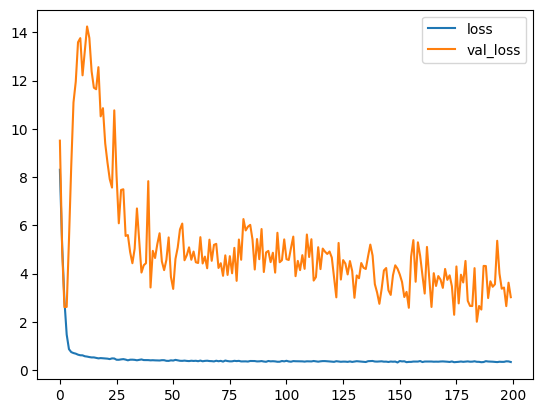

In [349]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

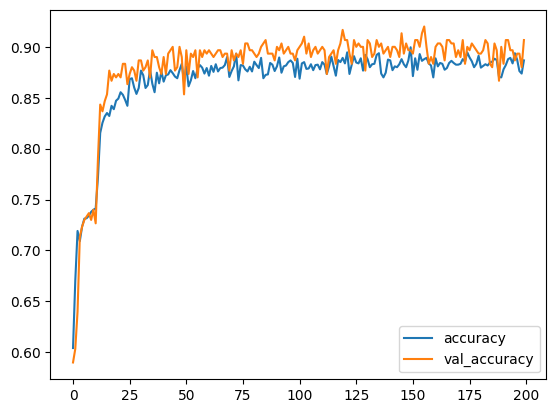

In [350]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [351]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.23592419922351837, 0.9399999976158142]

Train data evaluation:
[0.2571658492088318, 0.9287499785423279]


In [352]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

10/10 [==============================] - 0s 1ms/step


<Axes: >

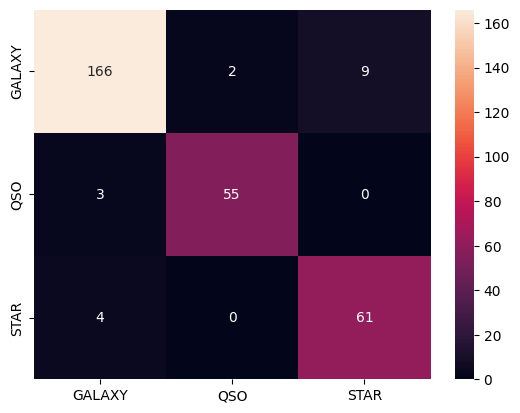

In [353]:
# Original heatmap without label names
# sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# you can also use the actual names for the categories
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [354]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

      GALAXY       0.96      0.94      0.95       177
         QSO       0.96      0.95      0.96        58
        STAR       0.87      0.94      0.90        65

    accuracy                           0.94       300
   macro avg       0.93      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300


Model overall accuracy: 94.00%


In [355]:
# Computing the ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

94/94 [==============================] - 0s 963us/step


0.9806634582367183

In [356]:
# Make a new test prediction

test_row = {
    'alpha': 140, 
    'delta': 35, 
    'u': 25, 
    'g': 23, 
    'r': 20, 
    'i': 20, 
    'z': 19,
    #'redshift': 4
}

# convert to pandas-format
tester_row = pd.DataFrame([test_row])
result = model.predict(tester_row)[0]
print(result.round(3))

result_index = np.argmax(result)
print(result_index)

# print the actual name with this index
result_text = categories[result_index]

# print the result
print(f"Predicted price range: {result_text}")

ValueError: in user code:

    File "d:\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "d:\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "d:\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Various Things\Engineering Study\Semester Spring 2024\Deep Learning\DeepLearning2024\.venv\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_14" is incompatible with the layer: expected shape=(None, 8), found shape=(None, 7)
